In [51]:
n_vars=30

# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/" 
# se_meta = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/anno_mt_af_v02/input/method_bias"
# method = "bias"



method = "bias"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_nuclear/variants_simpleUnion/method_bias/"
indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/"
se_meta = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"



conditions = None #"Input"
top_n = 30




In [52]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm



In [53]:
import mplh.cluster_help as ch
import mplh.fig_utils as fu
from mplh.color_utils import create_color_df_v02


### Smaller params

In [54]:
don_dirs = [d for d in glob(indir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1'}

In [55]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    variants = set(af.columns)
    return af, cov, variants


In [56]:
af_d = {}
cov_d = {}
for d in don_dirs: 
    curr_af, curr_cov, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    #curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    af_d[d] = curr_af
    cov_d[d] = curr_cov

In [57]:
# append any unseen variants in different donors
allVars = [set(af_d[d].columns) for d in af_d]
allVars = allVars[0].union(*allVars)
len(allVars)

for d in af_d:
    unseen_cols = allVars - set(af_d[d].columns.values)
    print('unseen_cols')
    print(unseen_cols)
    print(len(unseen_cols))
    af_d[d].loc[:, unseen_cols] = 0
    cov_d[d].loc[:, unseen_cols] = 0

unseen_cols
{'15497A', '11002G', '2992A'}
3
unseen_cols
{'189G', '13177A', '152C', '3243T'}
4


In [58]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

if "cluster_labels" in labels_df.columns:
    labels_df["labels"] = labels_df["cluster_labels"]
else:
    labels_df["labels"] = labels_df["seurat_clusters"]
   

(13593, 41)
(12188, 41)


In [59]:
if conditions != None and conditions != "None":
    conditions_l = conditions.split(",")
    labels_df = labels_df.loc[labels_df["condition"].isin(conditions_l)]
    print(labels_df.shape)

## Group by labels and donor 

In [60]:
all_cells=[]
for d in af_d:
    all_cells.extend(af_d[d].index.values)
all_cells = set(all_cells) #set([af_d[d].index.values for d in af_d])

print(labels_df.shape)
labels_df = labels_df[labels_df.index.isin(all_cells)]
print(labels_df.shape)

(12188, 42)
(12188, 42)


In [61]:
labels_df

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels,labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGGAGACTC-1_Flt3l,Flt3l,531,531,2286,298,7,7,124,749,1101,...,621,Flt3l_AAACGAAAGGAGACTC-1,0.0,AAACGAAAGGAGACTC-1,1.0,Flt3l,1,1.0,Neutrophil,Neutrophil
AAACGAAAGTCACGCC-1_Flt3l,Flt3l,1222,1222,4711,555,16,12,289,853,2986,...,1502,Flt3l_AAACGAAAGTCACGCC-1,1.0,AAACGAAAGTCACGCC-1,2.0,Flt3l,1,2.0,Erythrocyte,Erythrocyte
AAACGAACAAGACTAA-1_Flt3l,Flt3l,2225,2225,9178,1509,37,19,585,1339,5689,...,2695,Flt3l_AAACGAACAAGACTAA-1,2.0,AAACGAACAAGACTAA-1,3.0,Flt3l,1,3.0,Neutrophil,Neutrophil
AAACGAACAAGCGAAC-1_Flt3l,Flt3l,2271,2271,8825,1544,24,24,535,1308,5390,...,2784,Flt3l_AAACGAACAAGCGAAC-1,3.0,AAACGAACAAGCGAAC-1,4.0,Flt3l,0,1.0,Granulocyte,Granulocyte
AAACGAACACAGCCAC-1_Flt3l,Flt3l,2854,2854,10589,1294,41,31,456,2764,6003,...,2998,Flt3l_AAACGAACACAGCCAC-1,4.0,AAACGAACACAGCCAC-1,5.0,Flt3l,0,2.0,Non-classical monocyte,Non-classical monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTGTTTCTTAC-1_Input,Input,3580,3580,17067,3257,63,80,461,8097,5109,...,2899,Input_TTTGTGTGTTTCTTAC-1,13402.0,TTTGTGTGTTTCTTAC-1,13403.0,Input,0,6999.0,HSPC 1,HSPC 1
TTTGTGTTCCTGAAAC-1_Input,Input,4328,4328,30427,8323,84,99,799,12146,8976,...,4144,Input_TTTGTGTTCCTGAAAC-1,13403.0,TTTGTGTTCCTGAAAC-1,13404.0,Input,0,7000.0,MkP,MkP
TTTGTGTTCGGGAAAC-1_Input,Input,8010,8010,40114,14032,169,160,1561,10102,14090,...,5890,Input_TTTGTGTTCGGGAAAC-1,13404.0,TTTGTGTTCGGGAAAC-1,13405.0,Input,0,7001.0,HSPC 1,HSPC 1


## Sort variants by top ANOVA

In [62]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

def anova_mt(ser, cov_df, labels_df, min_cov=2):
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>min_cov]
    ser = ser.loc[curr_cov.index]
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].values for x in curr_labels["cluster_labels"].unique()]
    #print(len(curr_mt_groups))
    if len(curr_mt_groups) == 0:
        return pd.Series({"pval":1, "fval":0})
    if len(curr_mt_groups) <= 1:
        return pd.Series({"pval":1, "fval":0})
    
    if method == "anova":
        fvalue, pvalue = stats.f_oneway(*curr_mt_groups)
    return pd.Series({"pval":pvalue, "fval":fvalue})


def bias(ser, cov_df, labels_df, min_cov=2):
    #1/[max(ncells w variant in cluster)/sum(ncells w variant)]. the 1 is to make smaller values higher
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>=min_cov]
    ser = ser.loc[curr_cov.index]   
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].dropna().values for x in curr_labels["cluster_labels"].unique()]
    #print(curr_mt_groups)
    curr_mt_groups = [len(x[x>0]) for x in curr_mt_groups]
    if len(curr_mt_groups) == 0:
        return  pd.Series({"pval":1})
    
    return  pd.Series({"pval":1/(max(curr_mt_groups)/sum(curr_mt_groups))})


anova_d = {}
for d in af_d:
    if method=="anova":
        anova_out = af_d[d].apply(anova_mt, args=(cov_d[d],labels_df))
    else:
        anova_out = af_d[d].apply(bias, args=(cov_d[d],labels_df))
    anova_out
    anova_out_df = pd.DataFrame(anova_out)
    anova_out_df = anova_out_df.sort_values("pval", axis=1)
    anova_d[d] = anova_out_df
    

## Create clustermap

In [13]:
## 1. top variants by anova
## 2. min_coverage (2, 10)
## 3. Get af of cells that have one of the variants
## 4. Square root af, with a mask for coverage
## 5. sort cells by cluster (complexheatmap would be best)

In [14]:
# def plot_top(af, cov, anova_df, curr_labels_df, min_cov=2, top_n = 10):
#     curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
#     mt_vars = anova_df.columns[:top_n]
#     af = af.loc[:, mt_vars]
#     cov = cov.loc[:, mt_vars]
    
#     af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
#     cov = cov.loc[af.index, af.columns]
    
#     mask = cov.copy()
#     mask.loc[:,:] = False
#     mask[cov<min_cov] = True
    
#     # sort by curr_labels_df
#     curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
#     af = af.loc[curr_labels_df.index]
#     mask = mask.loc[curr_labels_df.index]
#     g = ch.plot_cluster(af ,row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
#                         row_clr_schemes="categorical", cmap="crest")
#     return g 

d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


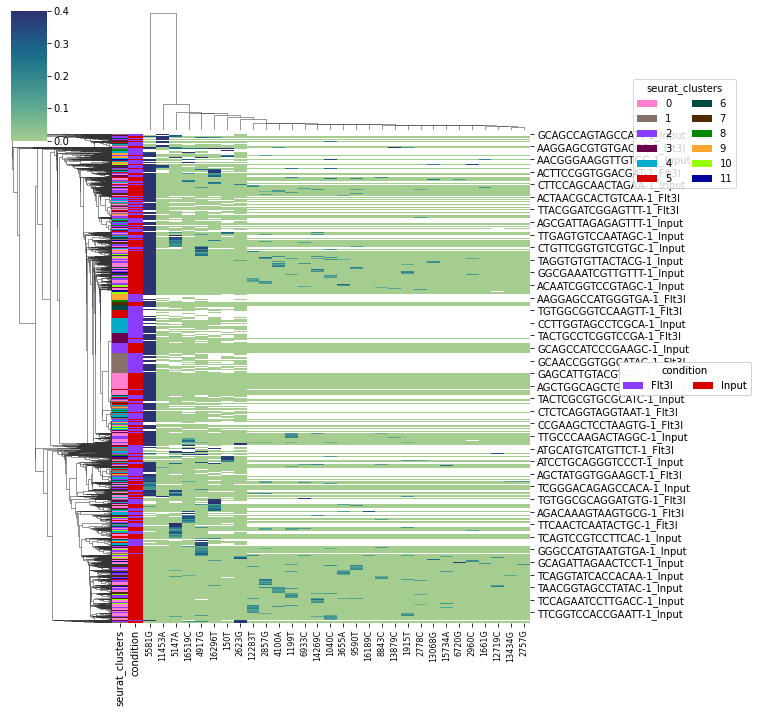

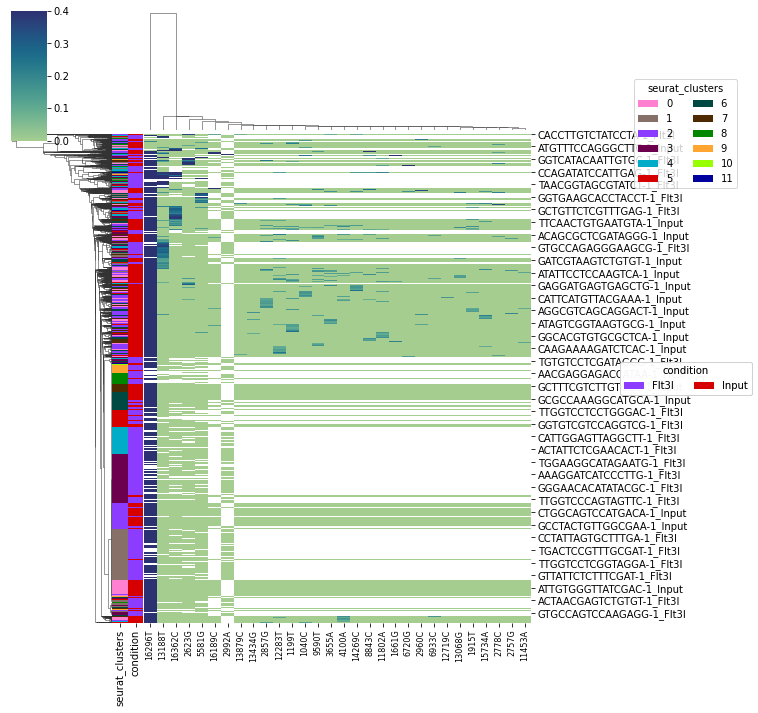

In [63]:
min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]    
    cov = cov.loc[af.index, af.columns]
    mask = mask.loc[af.index, af.columns] 
    

    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    
    
    mask = cov<min_cov
    #af[cov<min_cov] = np.nan
    def set_mask(ser, mask):
        curr = mask.loc[ser.name]
        ser[curr] = pd.NA
        return ser

    af_mask = af.apply(set_mask, args=(mask,) , axis=1)
    curr_labels_df[["seurat_clusters", "condition"]].to_csv(join(outdir, f"minCov10_donor{d}.labels.csv"))
    np.sqrt(af_mask).to_csv(join(outdir, f"minCov10_donor{d}.af.csv"))
    
    
    fu.helper_save(join(outdir, f"minCov10_donor{d}.af.pdf"))
#colormap.set_bad("black") 


In [64]:
af_mask.head()

,13188T,13434G,12283T,2857G,1661G,14269C,16296T,13068G,2778C,5581G,...,1915T,9590T,2960C,2623G,6933C,11453A,16362C,16189C,12719C,11802A
ID,,,,,,,,,,,,,,,,,,,,,
AGCTGTATCAGTACAC-1_Input,0.0,0.0,0.0,0.0,0.0,0.0,0.990476,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTACAAAGGTTACAA-1_Input,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.026667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTAAACCACCATTCC-1_Input,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGTAAACAGCGCACAA-1_Input,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.020619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGGTGCACACGTGAAG-1_Input,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.072727,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
af_mask.isnull().sum()

13188T     390
13434G    2744
12283T    2744
2857G     2744
1661G     2744
14269C    2744
16296T     923
13068G    2744
2778C     2744
5581G      757
3655A     2744
15734A    2744
4100A     2744
1040C     2744
1199T     2744
8843C     2745
6720G     2744
2757G     2744
2992A     3142
13879C    2744
1915T     2744
9590T     2744
2960C     2744
2623G      718
6933C     2744
11453A    2744
16362C     836
16189C    2744
12719C    2744
11802A    2744
dtype: int64

d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


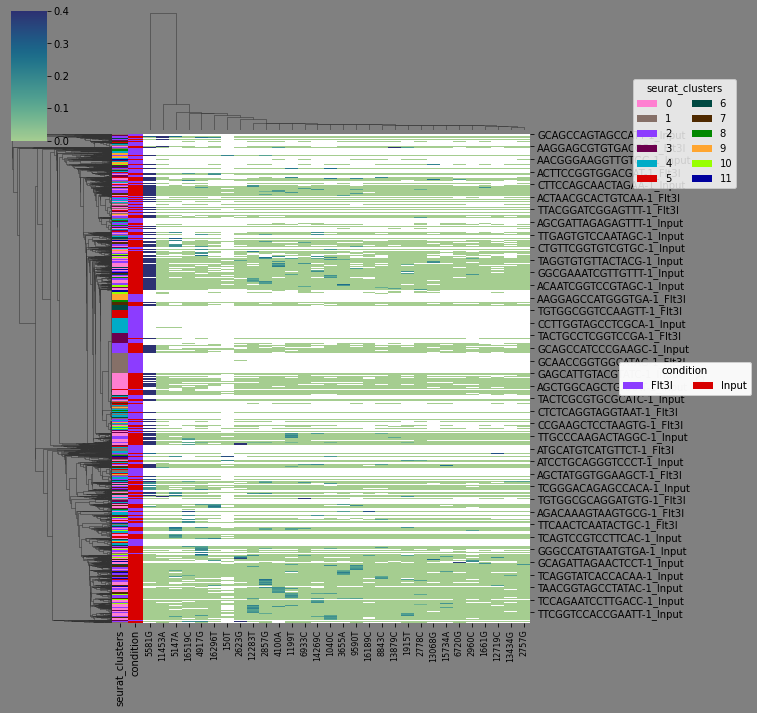

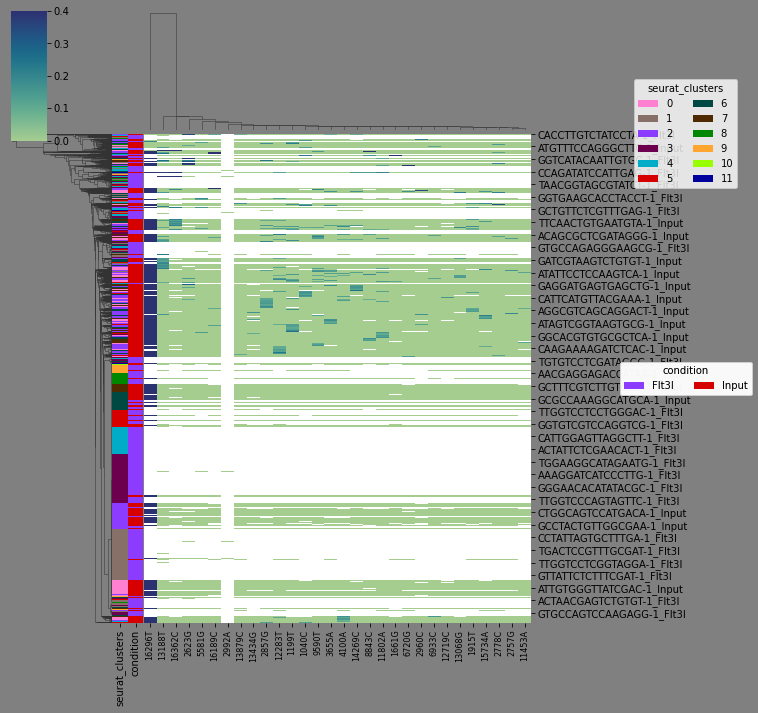

In [16]:
min_cov=50
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]    
    mask = mask.loc[af.index, af.columns]    
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')

#colormap.set_bad("black") 


### No clustering

d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']
d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


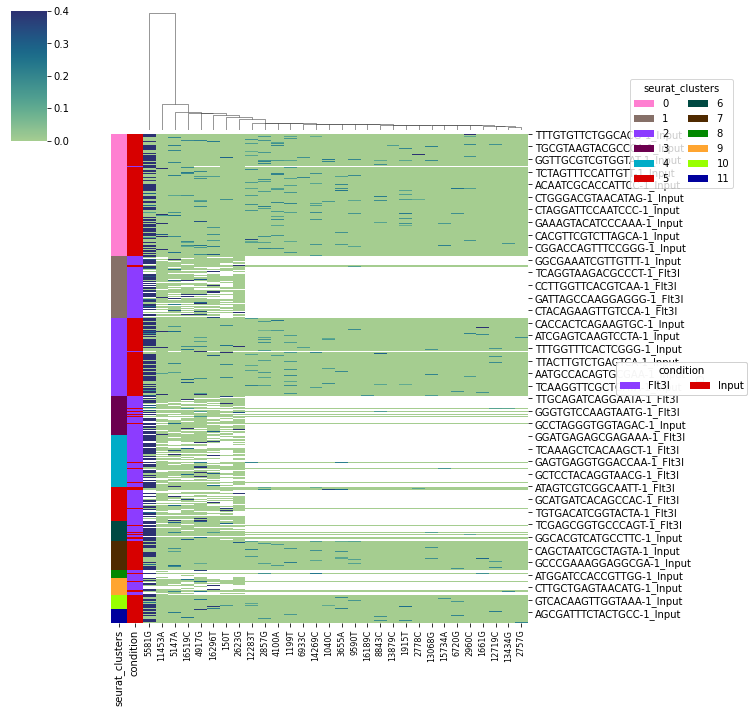

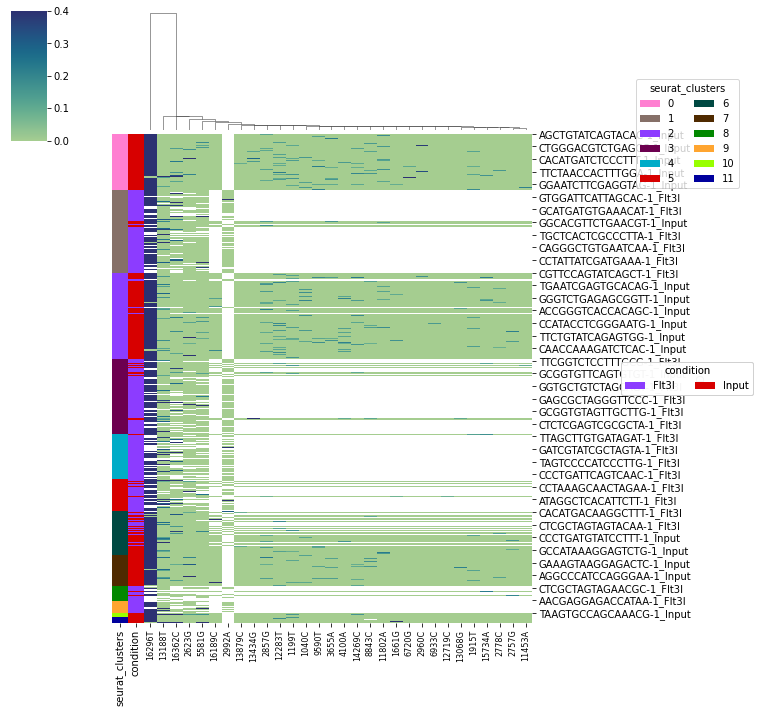

In [17]:
min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]
    
    mask = mask.loc[af.index, af.columns]
    #af = af.loc[af.index.isin(curr_labels_df.index)]
    
    #af[mask] = -1
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=False, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    fu.helper_save(join(outdir, f"minCov10_donor{d}.noCluster.af.pdf"))

In [20]:
#plot_top(af_d[0], cov_d[0], anova_d[0], labels_df, min_cov=2, top_n = 10)

In [36]:
# long_mt_af = []
# for d in af_d:
#     curr_mt_af = af_d[d].copy()
#     curr_mt_af["labels"] = [labels_df.loc[x,"labels"] if x in labels_df.index else None for x in curr_mt_af.index ]
#     curr_mt_af["condition"] = [labels_df.loc[x,"condition"] if x in labels_df.index else None for x in curr_mt_af.index ]
#     curr_mt_af["donor"] = d
#     curr_mt_af = curr_mt_af.reset_index().melt(id_vars=["Cell", "labels", "donor", "condition"], 
#                                                var_name="variant",
#                                                value_name="af")
#     #curr_mt_af["labels"] = [labels_df.loc[x,"labels"] for x in long_mt_af.index]
    
#     long_mt_af.append(curr_mt_af)
# long_mt_af = pd.concat(long_mt_af, axis=0)
# long_mt_af



# for don, val in long_mt_af.groupby("donor"):
#     vars_order = val.groupby("variant").mean()["af"].sort_values(ascending=False).index.values
#     g = sns.FacetGrid(data=val, col="variant", col_wrap=3, sharex=True, sharey=False, 
#                      height=4, col_order=vars_order, hue="condition")
#     g.map_dataframe(sns.boxenplot, x="labels", y="af")
    

# for don, val in long_mt_af.groupby("donor"):
#     vars_order = val.groupby("variant").mean()["af"].sort_values(ascending=False).index.values
#     g = sns.FacetGrid(data=val, col="variant", col_wrap=3, sharex=True, sharey=False, 
#                      height=4, col_order=vars_order)
#     g.map_dataframe(sns.boxenplot, x="labels", y="af")
    

,Cell,labels,donor,condition,variant,af
0,AAACGAACAAGCGAAC-1_Flt3l,5.0,0,Flt3l,13188T,1.000000
1,AAACGAACACAGCCAC-1_Flt3l,9.0,0,Flt3l,13188T,1.000000
2,AAACGAACACAGGTAG-1_Flt3l,3.0,0,Flt3l,13188T,1.000000
3,AAACGAACATAGAATG-1_Flt3l,4.0,0,Flt3l,13188T,0.000000
4,AAACGAAGTATTCGAC-1_Flt3l,9.0,0,Flt3l,13188T,0.947368
...,...,...,...,...,...,...
1132504,TTTGTGTCAATGACTC-1_Input,2.0,1,Input,3243T,0.000000
1132505,TTTGTGTCAGAAAGAG-1_Input,0.0,1,Input,3243T,0.000000
1132506,TTTGTGTCATAGCCAT-1_Input,0.0,1,Input,3243T,0.000000
1132507,TTTGTGTGTCATAGAA-1_Input,6.0,1,Input,3243T,0.000000


# Sort variants by variance

In [18]:
# def get_mt_mean(curr_df, af_d, labels_df):
#     print(curr_df.name)
#     lab, don = curr_df.name
#     cells = labels_df[(labels_df["donor"]==don) & (labels_df["labels"]==lab)].index
#     curr_af = af_d[int(don)]
#     return curr_af.loc[cells].mean(axis=0) #curr_af.loc[curr_af.index.isin(curr_df.index)].mean(axis=0)
 
# lin_mt_af = pd.DataFrame(index=labels_df.groupby(["labels", "donor"]).size().index, columns=allVars).apply(get_mt_mean, axis=1,args=(af_d, labels_df))
# lin_mt_af.head()




def get_mt_median(curr_df, af_d, labels_df):
    print(curr_df.name)
    lab, don = curr_df.name
    cells = labels_df[(labels_df["donor"]==don) & (labels_df["labels"]==lab)].index
    curr_af = af_d[int(don)]
    return curr_af.loc[cells].median(axis=0) #curr_af.loc[curr_af.index.isin(curr_df.index)].median(axis=0)
 
lin_mt_af = pd.DataFrame(index=labels_df.groupby(["labels", "donor"]).size().index, columns=allVars).apply(get_mt_median, 
                                                                                                           axis=1, args=(af_d, labels_df))
lin_mt_af.head()

(0, '0')
(0, '1')
(1, '0')
(1, '1')
(2, '0')
(2, '1')
(3, '0')
(3, '1')
(4, '0')
(4, '1')
(5, '0')
(5, '1')
(6, '0')
(6, '1')
(7, '0')
(7, '1')
(8, '0')
(8, '1')
(9, '0')
(9, '1')
(10, '0')
(10, '1')
(11, '0')
(11, '1')


10158C  10197A  10318C  10397G  1040C  10463C  10559G  10589A  \
labels donor                                                                  
0      0         0.0     0.0     0.0     1.0    0.0     0.0     0.0     1.0   
       1         0.0     0.0     0.0     0.0    0.0     1.0     1.0     0.0   
1      0         0.0     0.0     0.0     1.0    0.0     0.0     0.0     1.0   
       1         0.0     0.0     0.0     0.0    0.0     1.0     1.0     0.0   
2      0         0.0     0.0     0.0     1.0    0.0     0.0     0.0     1.0   

              10626C  1082G  ...  8926T  9087A  9173A  930A  9590T  9750A  \
labels donor                 ...                                            
0      0         0.0    0.0  ...    0.0    0.0    0.0   0.0    0.0    0.0   
       1         0.0    0.0  ...    0.0    0.0    0.0   1.0    0.0    0.0   
1      0         0.0    0.0  ...    0.0    0.0    0.0   0.0    0.0    0.0   
       1         0.0    0.0  ...    0.0    0.0    0.0   1.0    0.0    0.0   
2      0         0.0    0.0  ...    0.0    0.0    0.0   0.0    0.0    0.0   

              9823A  983T  9868A     9899C  
labels donor                                
0      0        0.0   0.0    0.0  0.000000  
       1        0.0   0.0    0.0  0.986441  
1      0        0.0   0.0    0.0  0.000000  
       1        0.0   0.0    0.0  0.916667  
2      0        0.0   0.0    0.0  0.000000  

[5 rows x 199 columns]

In [47]:
def get_cv(x):
    return np.std(x, ddof=1)/ np.mean(x) * 100


def order_bar(af, labels, **kwargs):
    df = pd.DataFrame({"AF":af, "clust": labels}) #, columns=['AF',"clust"])
    order = labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["labels"]
    #print(df)
    #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
    sns.barplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
    #sns.boxenplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2])#, hue_order=hue_order)
    #plt.xticks(rotation=45)
    return



/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


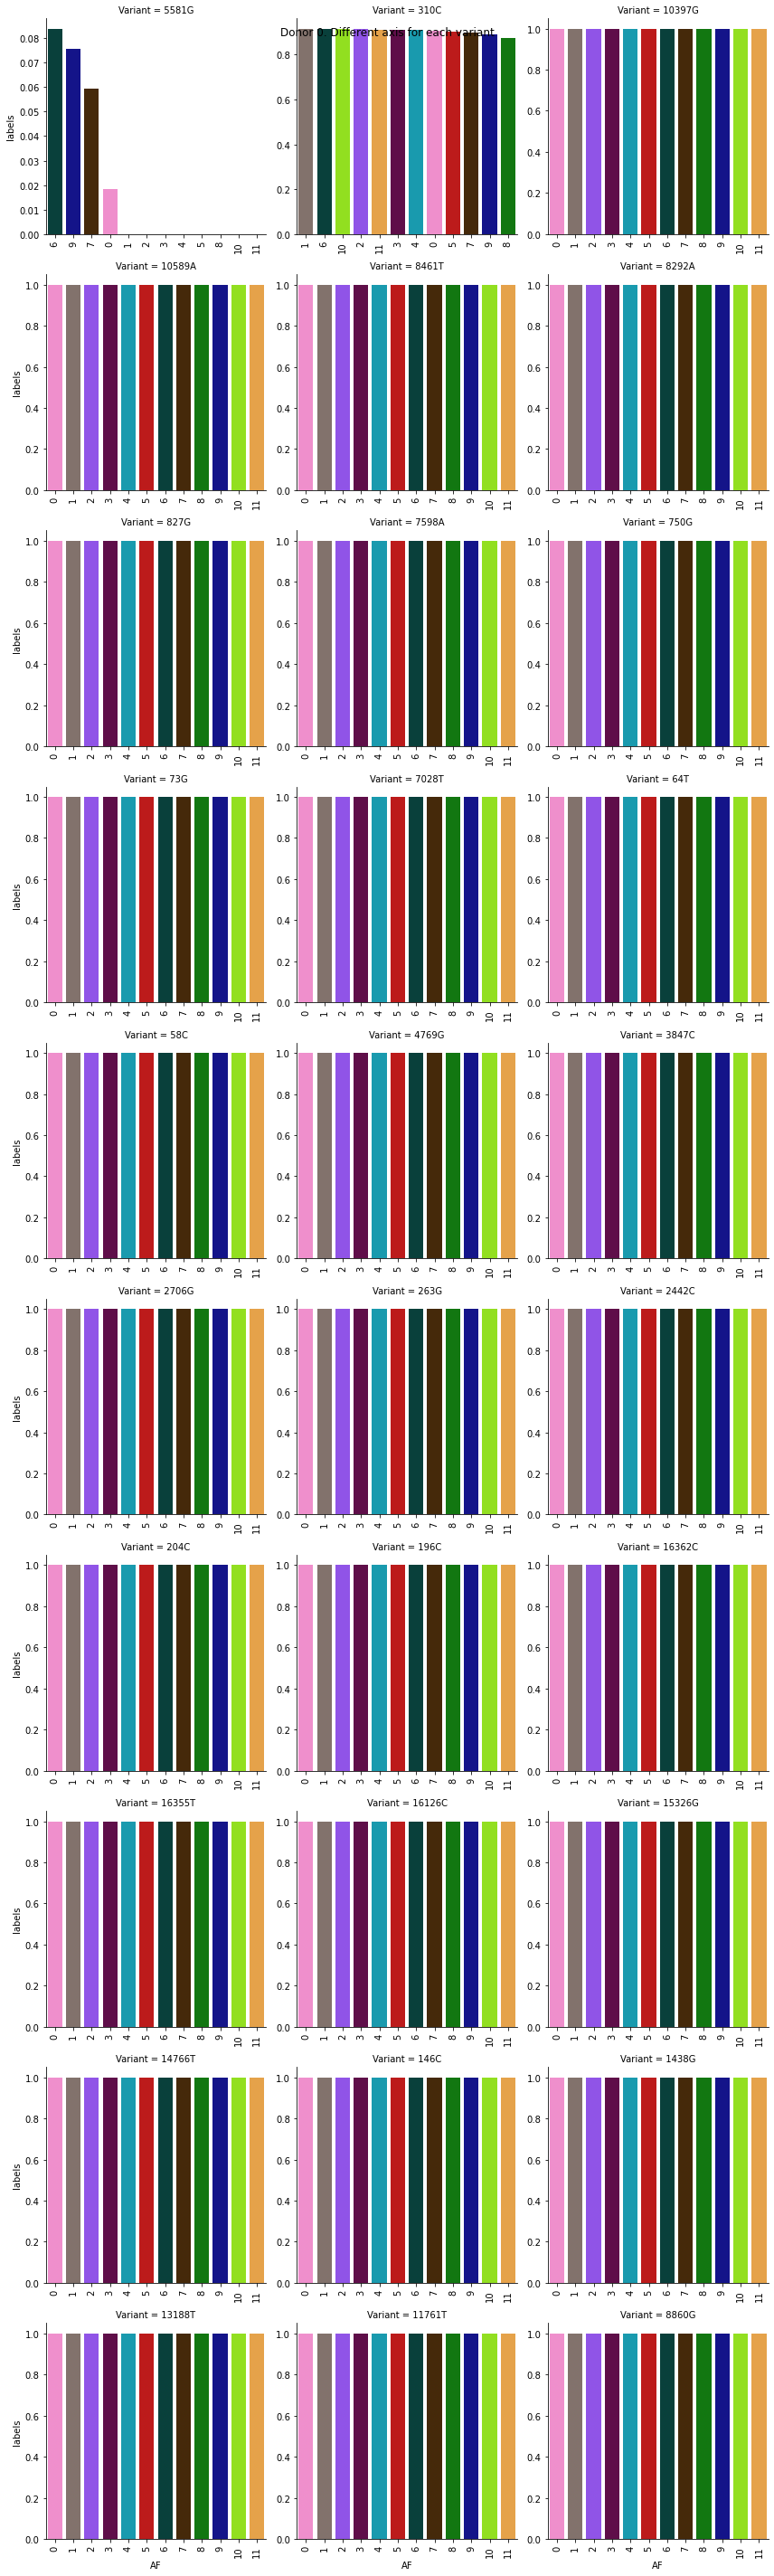

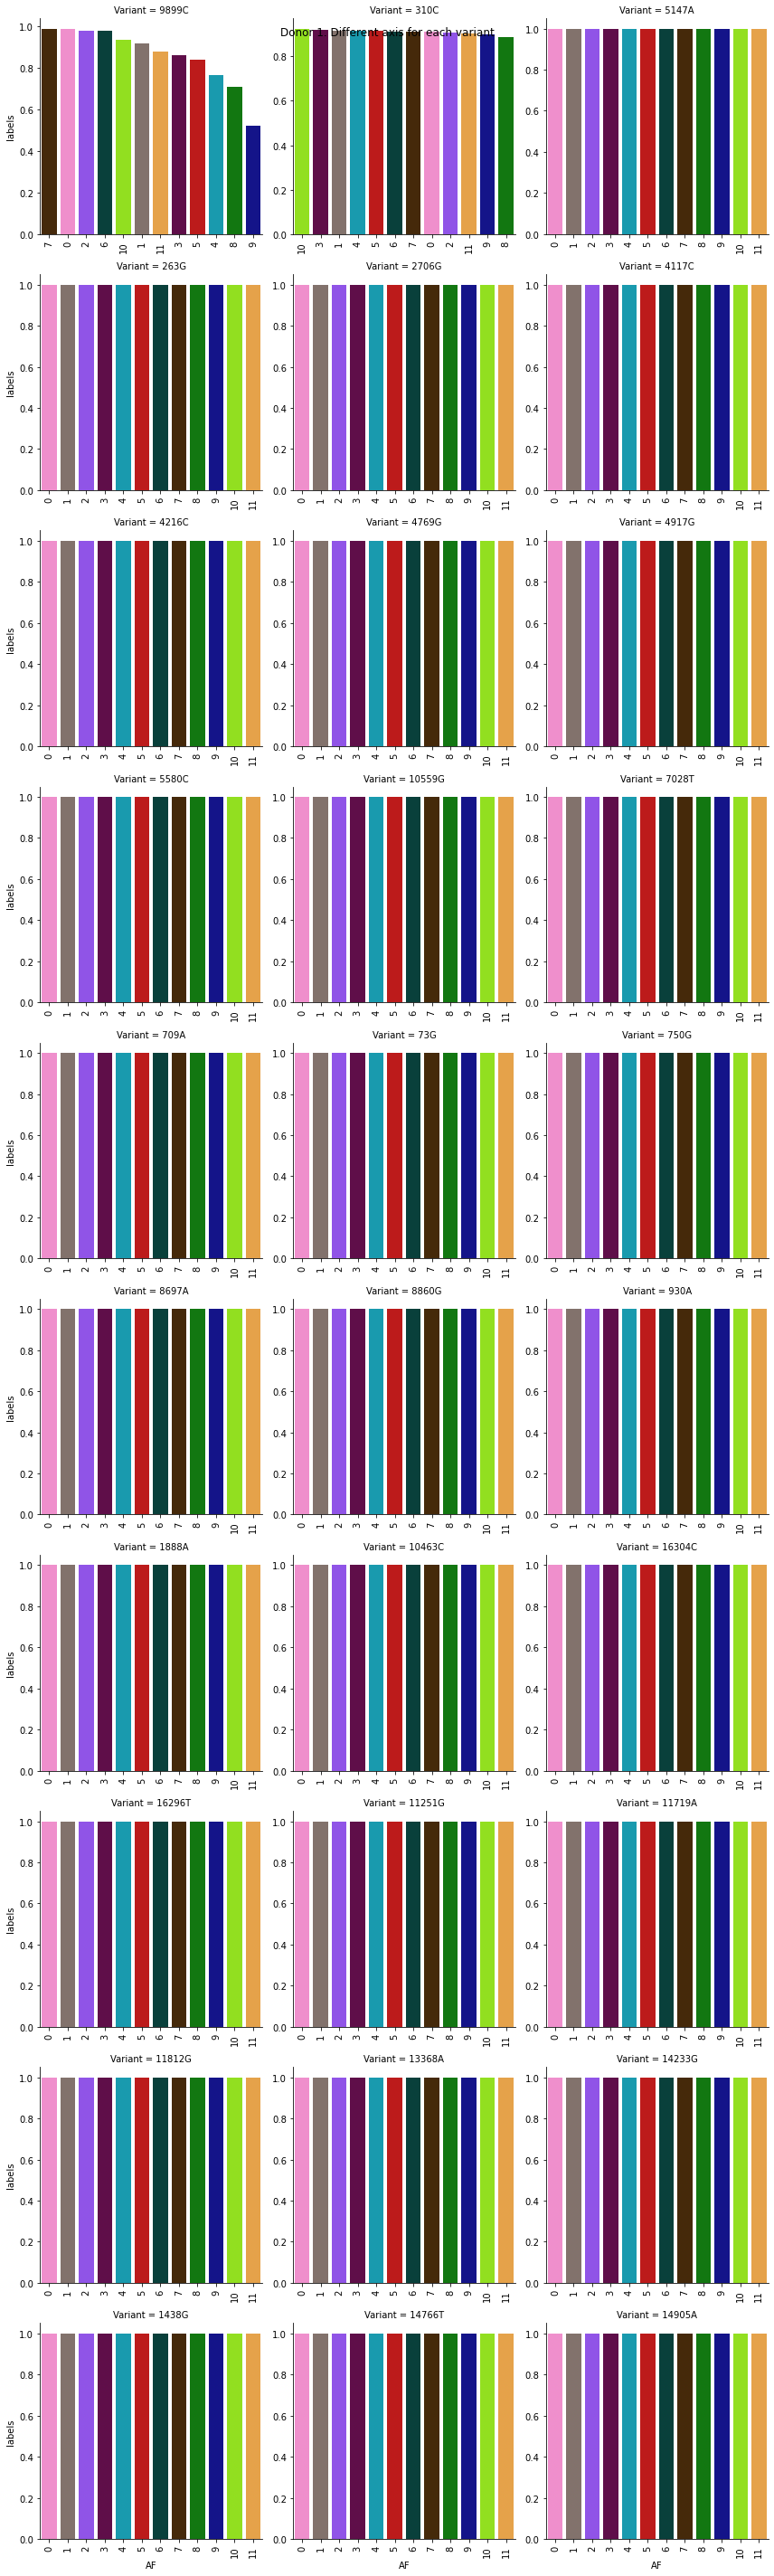

In [48]:
for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
    curr_don_mt = don_lin_mt_af.set_index(["labels","donor"])
    lin_mt_cv = curr_don_mt.apply(get_cv, axis=0).sort_values(ascending=False)
    curr_don_mt = curr_don_mt.loc[:,lin_mt_cv.index]

    lin_mt_af_w = curr_don_mt.iloc[:,:n_vars].reset_index().melt(id_vars=["labels", "donor"], var_name="Variant", value_name="AF")
    #print(lin_mt_af_w)
    lin_mt_af_w["donor"] = lin_mt_af_w["donor"].astype(str)
    lin_mt_af_w["labels"] = lin_mt_af_w["labels"].astype(str)
    hue_order = lin_mt_af_w["labels"].unique()
    color_out = create_color_df_v02(lin_mt_af_w, col="labels", clr_type='categorical')
    
#    g = sns.catplot(x="labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
 #               sharey=False, sharex=False, hue=None)
    g = sns.FacetGrid(col="Variant", data=lin_mt_af_w, col_wrap=3, sharex=False, sharey=False, 
                      hue_order=hue_order,height=4)
    g.map(order_bar, "AF", "labels")
    g.set_xticklabels(rotation=90)
    g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
    g.fig.tight_layout()